<a href="https://colab.research.google.com/github/RossanadC/Machine-Learning/blob/Lab2/Lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import packages**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# numpy and pytorch are already installed
import numpy as np

**Define a Neural Network**

In [ ]:
# define neural network
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(28*28, 512)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(512, 512)
        self.act2 = nn.ReLU()

        self.output_layer = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, 28, 28) => (batch_size, 28*28)

        # first layer (input is x, output is x1)
        x1 = self.lin1(x)
        x1 = self.act1(x1)

        # second layer (input is x1, output is x2)
        x2 = self.lin2(x1)
        x2 = self.act2(x2)

        # third/output layer (input is x2, output is logits)
        logits = self.output_layer(x2)
        return logits


**Dataset**

In [ ]:
from torchvision import datasets, transforms

# preprocessing to apply on each data sample:
# 1) convert to tensor
# 2) normalize images
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize a tensor image with mean and standard deviation.
        ])

# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)


**Validation set**

In [ ]:
train_data, validation_data=torch.utils.data.random_split(train_data, [0.9,0.1])

**Plot one sample from dataset**

In [ ]:
image, label = train_data[100]

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
label

6

In [ ]:
# dataset returns one sample at a time
# In our case one sample corresponds to a Tuple: (Image, Target Label)
# Image is a tensor with shape [1, 28, 28]
# Label is an integer representing the class of the image

print(type(train_data[100]))
print(len(train_data[100]))

image, label = train_data[100]
print("image: ", image.shape, type(image))
print("label: ", label, type(label))

<class 'tuple'>
2
image:  torch.Size([1, 28, 28]) <class 'torch.Tensor'>
label:  6 <class 'int'>


In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
image[0].shape

torch.Size([28, 28])

In [ ]:
image=image.view(28,28)
image.shape

torch.Size([28, 28])

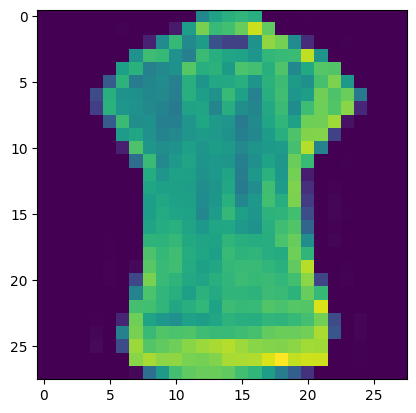

In [ ]:
# plot one sample normalized

import matplotlib.pyplot as plt
plt.imshow(image.numpy())  # numpy array 28x28

**DataLoader**

In [ ]:
batch_size = 128  # we define here the batch size: number of samples processed before the model is updated
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) #, drop_last=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False) # , drop_last=False)
print(f"batch size: {batch_size}")

batch size: 128


**Traning**

In [ ]:
# function for training
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # model to train mode

    # ITERATE DATALOADER: train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        #  SINGLE OPTIMIZATION STEP IS PERFORMED ON A BATCH!
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# test
# function for evaluation
def test(model, device, test_loader):
    model.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
device = torch.device('cuda')  # use gpu, is equivalent to .cuda()

# training hyperparameters
lr = 0.01
num_epochs = 30
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_data)/batch_size)}")

#########
# MODEL #
#########
model = NeuralNetwork(num_classes=10)
model = model.to(device)

#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 421


In [ ]:
%%time
for epoch in range(1, num_epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.330357
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.694588
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.589771
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.550117
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.412640
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.571668
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.376872
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.501848
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.535670

Test set: Average loss: 0.4202, Accuracy: 45817/54000 (85%)

Train Epoch: 2 [0/54000 (0%)]	Loss: 0.428738
Train Epoch: 2 [6400/54000 (12%)]	Loss: 0.373340
Train Epoch: 2 [12800/54000 (24%)]	Loss: 0.308762
Train Epoch: 2 [19200/54000 (36%)]	Loss: 0.363187
Train Epoch: 2 [25600/54000 (47%)]	Loss: 0.398268
Train Epoch: 2 [32000/54000 (59%)]	Loss: 0.322624
Train Epoch: 2 [38400/54000 (71%)]	Loss: 0.332073
Train Epoch: 2 [44800/54000 (83%)]	Loss: 0.342679
Train Epoch: 2 [51200/54000 (95%)]	Loss: 0.347028

Test set: Average loss: 0.3324, Accuracy: 47470/5